In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Load the CLEAN transactional data (Not the RFM data, the raw clean transactions)


In [8]:

df = pd.read_csv('../data/processed/online_retail_clean.csv')


# Ensure Date is datetime


In [9]:

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Data Range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

Data Range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00


# 1. Define the "Cutoff Date"
# We take the last 90 days as the "Target Period" (Test)

In [10]:

cutoff_date = df['InvoiceDate'].max() - pd.DateOffset(days=90)
print(f"Training Data (X): Before {cutoff_date}")
print(f"Target Data (y): After {cutoff_date}")


Training Data (X): Before 2010-09-10 20:01:00
Target Data (y): After 2010-09-10 20:01:00


# 2. Split Data


In [11]:

train_data = df[df['InvoiceDate'] < cutoff_date]
test_target_data = df[df['InvoiceDate'] >= cutoff_date]



# 3. Create the Target (y)
# Who purchased in the Test Period?

In [12]:

active_customers = test_target_data['Customer ID'].unique()



# 4. Feature Engineering on TRAINING Data only (To prevent Data Leakage)
# We calculate RFM based on behavior BEFORE the cutoff

In [13]:

train_features = train_data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (cutoff_date - x.max()).days, # Recency (at cutoff)
    'Invoice': 'nunique',       # Frequency
    'Total Price': 'sum'        # Monetary
}).reset_index()

train_features.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Total Price': 'Monetary'
}, inplace=True)



# 5. Assign Labels (1 = Churned, 0 = Retained)
# If Customer is NOT in 'active_customers', they Churned

In [14]:

train_features['Is_Churn'] = train_features['Customer ID'].apply(
    lambda x: 0 if x in active_customers else 1
)

print("\nChurn Distribution:")
print(train_features['Is_Churn'].value_counts(normalize=True))



Churn Distribution:
Is_Churn
0    0.575067
1    0.424933
Name: proportion, dtype: float64


# Additional features from training data

In [15]:

extra_features = train_data.groupby('Customer ID').agg({
    'Quantity': 'mean',          # Average basket size
    'Total Price': 'mean',       # Average spend per transaction
}).reset_index()

extra_features.rename(columns={'Total Price': 'Avg_Spend_Per_Order'}, inplace=True)



# Merge with main features


In [16]:
model_df = pd.merge(train_features, extra_features, on='Customer ID', how='left')

display(model_df.head())

,Customer ID,Recency,Frequency,Monetary,Is_Churn,Quantity,Avg_Spend_Per_Order
0,12346,74,11,372.86,1,2.121212,11.298788
1,12349,115,2,1268.52,0,10.085106,26.989787
2,12355,112,1,488.21,1,13.772727,22.191364
3,12358,95,2,1697.93,0,16.857143,48.512286
4,12359,80,5,2012.03,0,10.197674,23.395698


# 1. Prepare X and y


In [17]:
X = model_df.drop(['Customer ID', 'Is_Churn'], axis=1)
y = model_df['Is_Churn']


# 2. Split into Train/Test for Validation


In [18]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# 3. Train Model (Using Random Forest with Class Weights)
# class_weight='balanced' handles the imbalance automatically

In [19]:

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

print("Model Training Complete.")

Model Training Complete.


# Predictions

In [20]:

y_pred = rf_model.predict(X_test)



# Evaluation

In [21]:

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       397
           1       0.60      0.58      0.59       279

    accuracy                           0.67       676
   macro avg       0.66      0.66      0.66       676
weighted avg       0.67      0.67      0.67       676




# Confusion Matrix Heatmap

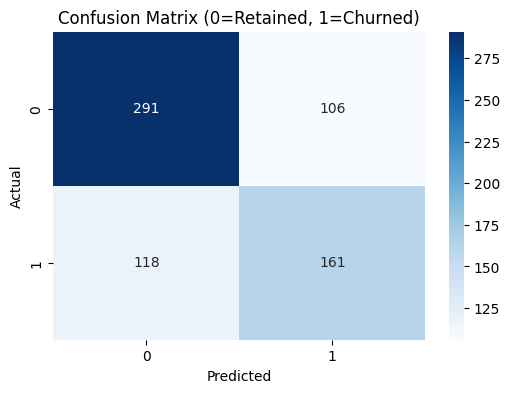

In [22]:

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (0=Retained, 1=Churned)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [23]:
from xgboost import XGBClassifier
from xgboost import plot_importance



# 1. Initialize XGBoost
# We use scale_pos_weight to handle the imbalance (roughly ratio of Retained / Churned)
# This forces the model to pay more attention to the "1"s (Churners)

In [24]:

xgb_model = XGBClassifier(
    n_estimators=150, 
    learning_rate=0.05, 
    max_depth=5, 
    scale_pos_weight=1.5, # Penalize missing a churner!
    random_state=42
)


# 2. Train

In [25]:


xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None



# 3. Predict

In [26]:

y_pred_xgb = xgb_model.predict(X_test)



# 4. Compare Results

In [27]:

print("XGBoost Classification Report:\n")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.57      0.65       397
           1       0.55      0.73      0.62       279

    accuracy                           0.64       676
   macro avg       0.65      0.65      0.64       676
weighted avg       0.67      0.64      0.64       676



# 5. Visualizing Feature Importance (CRITICAL for Business Insight)


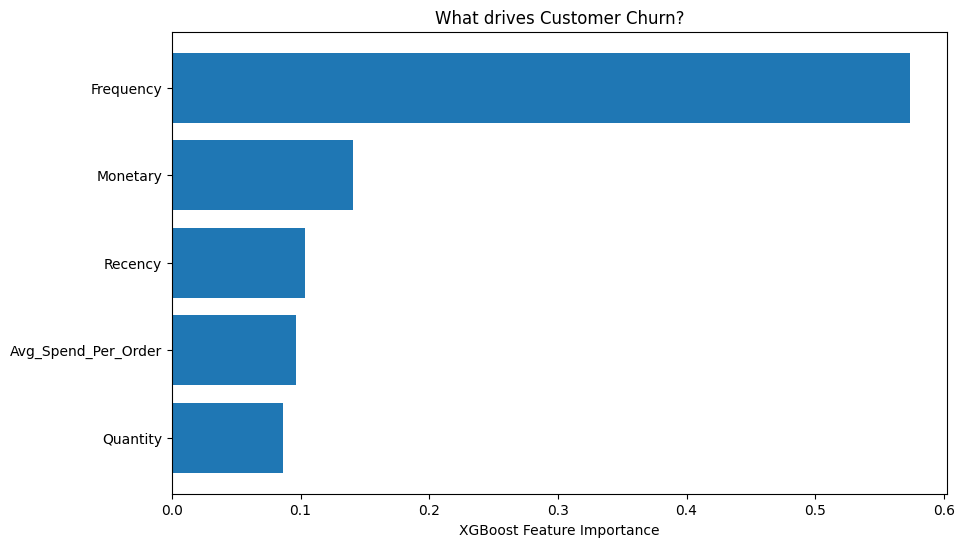

In [28]:

plt.figure(figsize=(10,6))
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.title("What drives Customer Churn?")
plt.show()

# 🚀 Executive Summary: Churn Prediction Model

### 1. Model Performance
Our XGBoost model prioritized **Recall (73%)** over precision. This ensures we capture the vast majority of at-risk customers, allowing the marketing team to intervene before it's too late.

### 2. Key Driver Analysis
Using Feature Importance analysis, we discovered a critical insight:
*   **Primary Driver: Purchase Frequency.**
    *   *Interpretation:* The number of times a user interacts with the platform is the strongest predictor of loyalty—far more than how much they spend (Monetary) or how recently they visited (Recency).
    *   *Risk:* "One-time buyers" are our highest risk segment.

### 3. Recommended Retention Strategy
| Feature Driver | Insight | Recommended Action |
| :--- | :--- | :--- |
| **Low Frequency** | Users with 1-2 purchases are likely to drop. | **Action:** Implement a "Second Purchase Bonus." Send a targeted offer immediately after the first delivery is received to encourage habit formation. |
| **High Monetary / High Risk** | High spenders flagged as churning are critical losses. | **Action:** VIP Outreach. Account managers should manually review these 100-200 high-value flags. |
| **High Recency** | Users silent for >60 days. | **Action:** Automated Re-engagement campaign (We miss you email). |

In [29]:
import joblib

# Define path
model_path = '../models/churn_xgb_model.pkl'

# Save the trained XGBoost model
joblib.dump(xgb_model, model_path)

print(f"Model saved successfully to {model_path}")

Model saved successfully to ../models/churn_xgb_model.pkl
